In [81]:
import os
import sys

import numpy as np

import paths
import pickle
import importlib

sys.path.append("..")
from models.utils import *
from models.plotting_utils import *
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from streamfunction_ecco import streamfunction_custom_utils as strf_utils

import matplotlib.pyplot as plt

In [82]:
importlib.reload(paths)

<module 'paths' from 'C:\\Users\\aline\\OTP\\paths.py'>

In [83]:
data_home = paths.LOCAL_DIR
lats = [26, -30, -55, -60]

In [84]:
PSI_RAPID = xr.open_dataset(os.path.join(paths.RAPID_ARRAY, "moc_vertical.nc"))
PSI_RAPID = PSI_RAPID.rename({'depth': 'k'})
PSI_RAPID['k'] = - PSI_RAPID['k']
PSI_RAPID = PSI_RAPID.rename_vars({'stream_function_mar': 'psi_moc'})
PSI_RAPID['lat'] = ('lat', [26.5])

new_order = ['k', 'lat', 'time']
other = PSI_RAPID.transpose(*new_order)

other

<xarray.Dataset>
Dimensions:  (time: 13057, k: 307, lat: 1)
Coordinates:
  * time     (time) datetime64[ns] 2004-04-02 2004-04-02T12:00:00 ... 2022-02-15
  * k        (k) float64 -0.0 -19.87 -39.74 ... -5.956e+03 -5.976e+03 -5.995e+03
  * lat      (lat) float64 26.5
Data variables:
    psi_moc  (k, time) float64 ...
Attributes:
    Title:                         RAPID streamfunction
    Institution:                   National Oceanography Centre,UK
    Website:                       http://www.rapid.ac.uk/rapidmoc
    Acknowledgement:               The RAPID 26N AMOC monitoring project is f...
    Created_by:                    Ben Moat
    Creation_date:                 08-Sep-2023
    Principle_investigator:        Ben Moat
    Principle_investigator_email:  ben.moat@noc.ac.uk
    DOI:                           doi: 10.5285/04c79ece-3186-349a-e063-6c86a...

In [194]:
lat = lats[1]
lat_str = strf_utils.format_lat_lon(lat)

lon_min = -50
lon_max = 17

inputs = xr.open_dataset(f"{data_home}/ecco_data_minimal/{lat_str}.nc").isel(latitude=slice(1,2))
inputs = inputs.sel(longitude=slice(lon_min, lon_max))

In [195]:
#outputs = xr.open_dataset(f"{data_home}/streamfunctions_ecco/{lat}/PSI_residual{lat}.nc")
extra_str = 'moc'
outputs_fp = f"{data_home}/ecco_data_minimal/{lat_str}_{extra_str}_depth.pickle"

with open(outputs_fp, 'rb') as f:
    outputs = pickle.load(f).astype(np.float64)
outputs = np.expand_dims(outputs, 1) # grabbing just 30S
print(outputs.shape)

outputs = xr.Dataset(data_vars = {'moc' : (["time", "latitude"], outputs)}, coords = {'time' : inputs.time, 'latitude' : np.atleast_1d(-60),})

outputs

(312, 1)


<xarray.Dataset>
Dimensions:   (time: 312, latitude: 1)
Coordinates:
  * time      (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
  * latitude  (latitude) int32 -60
Data variables:
    moc       (time, latitude) float64 -17.03 -14.71 -11.87 ... -13.84 -17.46

In [197]:
#outputs = xr.open_dataset(f"{data_home}/streamfunctions_ecco/{lat}/PSI_residual{lat}.nc")
#extra_str = 'moc'
extra_str = 'atlantic_sf'
strf_fp = f"{data_home}/ecco_data_minimal/{lat_str}_{extra_str}_depth.pickle"
ECCO_GRID = xr.open_dataset(paths.geom_fp)

with open(strf_fp, 'rb') as f:
    strf = pickle.load(f).astype(np.float64)
strf = np.expand_dims(strf[:, 1, :], 1) # grabbing just 30S
strf = np.transpose(strf, (2,0,1))
print(strf.shape)

strf = xr.Dataset(data_vars = {'moc' : (["time", "k", "latitude"], strf)}, coords = {'time' : inputs.time,  'k': np.arange(50), 'latitude' : np.atleast_1d(-60),})

strf = strf.assign_coords(Z=('k', ECCO_GRID.coords['Z'].data))
strf

(312, 50, 1)


<xarray.Dataset>
Dimensions:   (time: 312, k: 50, latitude: 1)
Coordinates:
  * time      (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
  * k         (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * latitude  (latitude) int32 -60
    Z         (k) float32 -5.0 -15.0 -25.0 ... -5.039e+03 -5.461e+03 -5.906e+03
Data variables:
    moc       (time, k, latitude) float64 -0.0 -0.0 0.2408 ... -1.626 -0.2377

In [213]:
importlib.reload(strf_utils)

<module 'streamfunction_ecco.streamfunction_custom_utils' from 'C:\\Users\\aline\\OTP\\streamfunction_ecco\\streamfunction_custom_utils.py'>

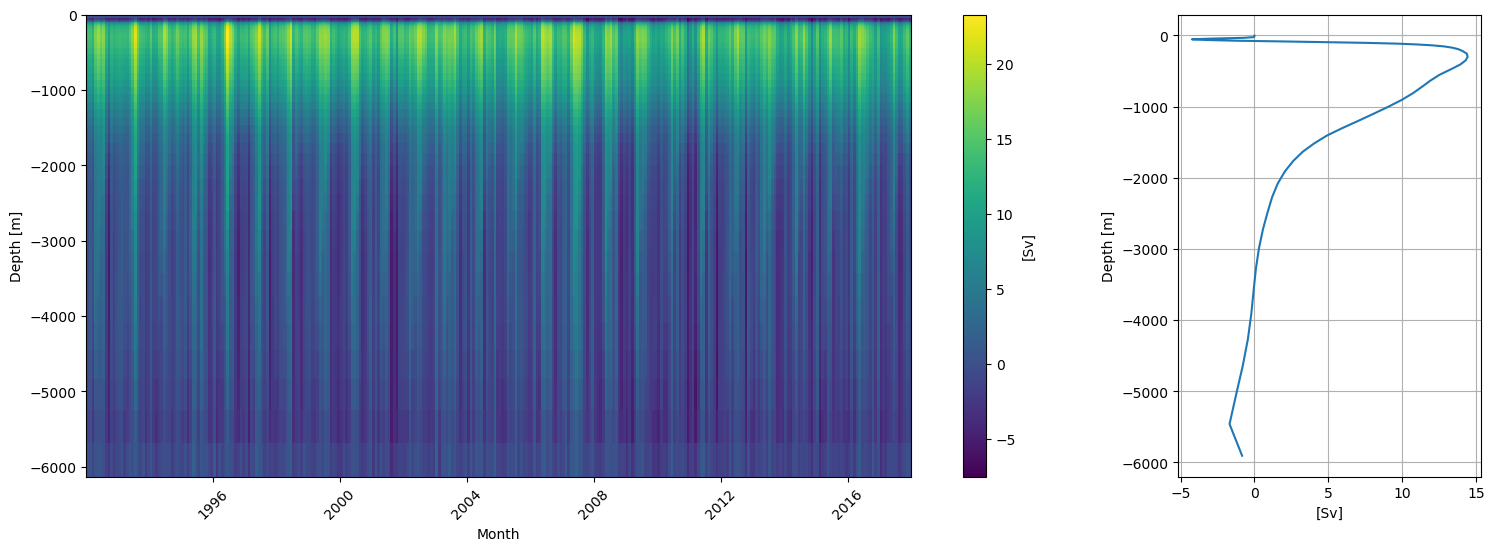

In [214]:
fig = plt.figure(figsize=(18,6))
plt.subplot(1,4,(1,3))

stf_ds = strf.squeeze()
time_edge_extrap = np.hstack((stf_ds['time'].values[0] - (0.5*np.diff(stf_ds['time'].values[0:2])),\
                                  stf_ds['time'].values[:-1] + (0.5*np.diff(stf_ds['time'].values)),\
                                  stf_ds['time'].values[-1] + (0.5*np.diff(stf_ds['time'].values[-2:]))))
Z_edge_extrap = np.hstack((np.array([0]),\
                               stf_ds['Z'].values[:-1] + (0.5*np.diff(stf_ds['Z'].values)),\
                               np.array([-6134.5])))
plt.pcolormesh(time_edge_extrap, Z_edge_extrap, stf_ds['moc'].T)
plt.ylabel('Depth [m]')
plt.xlabel('Month')
plt.xticks(rotation=45)
cb = plt.colorbar()
cb.set_label('[Sv]')

plt.subplot(1,4,4)
plt.plot(stf_ds['moc'].mean('time'),stf_ds['Z'])
plt.ylabel('Depth [m]')
plt.xlabel('[Sv]')
plt.grid()
plt.show()

In [217]:
outputs_upper_cell = strf_utils.get_PSI_at_max_density_level(stf_ds, moc_param='moc', max=True)
outputs_bottom_cell = strf_utils.get_PSI_at_max_density_level(stf_ds, moc_param='moc', max=False)

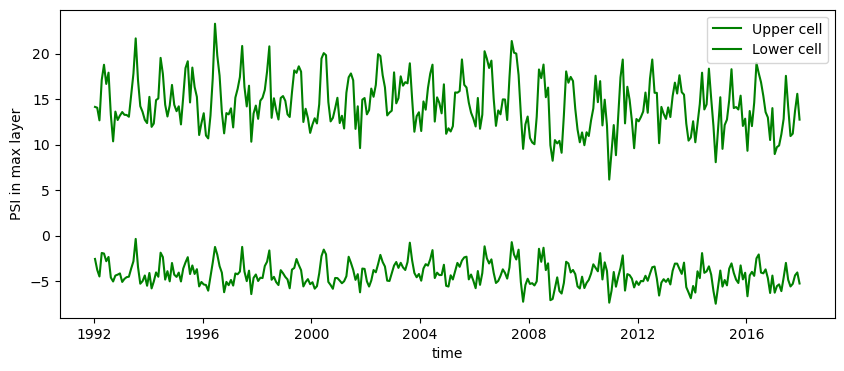

In [218]:
psi_data_upper = outputs_upper_cell
psi_data_lower = outputs_bottom_cell

plt.figure(figsize = (10, 4))
plt.plot(psi_data_upper["time"].squeeze(), psi_data_upper["moc"].squeeze(), color='green', label='Upper cell')   
plt.plot(psi_data_lower["time"].squeeze(), psi_data_lower["moc"].squeeze(), color='green', label='Lower cell') 
plt.xlabel('time')
plt.ylabel('PSI in max layer')
plt.legend()

In [203]:
date_range = (inputs.time.values[0], inputs.time.values[-1]) # grabbing start and end date for inputs
date_range = tuple([str(d).split('T')[0] for d in date_range]) # extracting just the date, w/o time
print('Date range to align to:', date_range)
inputs, outputs = align_inputs_outputs(inputs, outputs, date_range = date_range, ecco=False)

Date range to align to: ('1992-01-16', '2017-12-16')


In [170]:
# apply whatever preprocessing we want *before* calling reshape_inputs
pp_data = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=False,
                              remove_trend=False,
                              standardize=True,
                              lowpass=False)

# reshape as desired and convert to a numpy array
pp_data_np = reshape_inputs(pp_data, keep_coords=["time", "longitude"])

# MOC strength from data
strength = apply_preprocessing(outputs,
                               mode="outputs",
                               remove_season=False,
                               remove_trend=False,
                               standardize=False,
                               lowpass=False)
strength_np = strength.moc.squeeze().values
X = pp_data_np
    
# Necessary step to do convolutions along the right axis with pytorch tensors!
dims = list(range(X.ndim))  
dims[1], dims[-1] = dims[-1], dims[1]
print(dims)
X = np.transpose(X, dims)

conv_dims = 2
if len(X.shape) == (conv_dims + 1):
    X = np.expand_dims(X, axis=-1)
print(X.ndim)

y = strength_np[-X.shape[0]:]

print()
print('Inputs shape:', X.shape)
print('Outputs shape:', y.shape)

axes: ['time', 'longitude', 'feature']
variables: ['SSH', 'SST', 'SSS', 'OBP', 'ZWS']
shape: (312, 440, 5)
[0, 2, 1]
4

Inputs shape: (312, 5, 440, 1)
Outputs shape: (312,)


In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, stratify=None, random_state=123456)

device = "cuda" if t.cuda.is_available() else "cpu"
print(f"device: {device}")

Xt_train = t.tensor(X_train, device=device).double()
Yt_train = t.tensor(y_train, device=device).double()
Xt_test = t.tensor(X_test, device=device).double()
Yt_test = t.tensor(y_test, device=device).double()

device: cpu


In [172]:
import importlib
from models import train, SimDataset, CNN1D, CNN2D, CNN3D

importlib.reload(train)
importlib.reload(CNN1D)
importlib.reload(CNN2D)
importlib.reload(SimDataset)

<module 'models.SimDataset' from 'C:\\Users\\aline\\OTP\\models\\SimDataset.py'>

device: cpu
931 parameters.


100%|██████████| 2500/2500 [00:53<00:00, 46.95it/s]


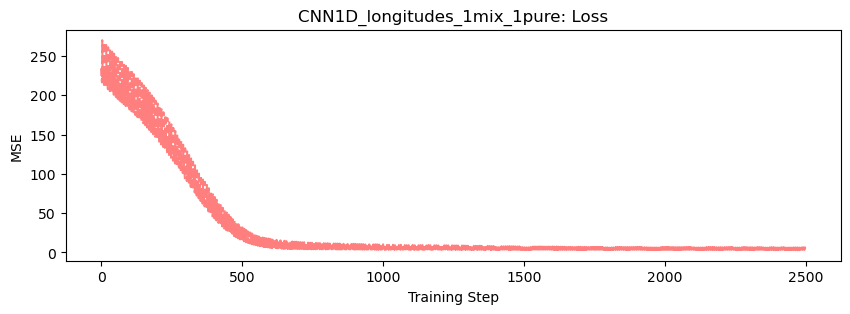

final loss: 6.0786957762754925
model saved to H:/.shortcut-targets-by-id/1wvJjD0RMTujKYaXQapEiGk-Mx03_KSin/GTC\ecco_models/saved_models/CNN1D_longitudes_1mix_1pure.pt
loss curve saved to H:/.shortcut-targets-by-id/1wvJjD0RMTujKYaXQapEiGk-Mx03_KSin/GTC\ecco_models/loss_curves/CNN1D_longitudes_1mix_1pure.png


In [173]:
dropout = 0.2
n_pure_layers = 1
n_mix_layers = 1
n_features = 5
n_channels = n_features * 3
kernel_size = (3,3)

model = CNN2D.CNN2D(
    n_pure_layers=n_pure_layers, 
    n_mix_layers=n_mix_layers, 
    n_features=n_features, 
    n_channels=n_channels,
    kernel_size=kernel_size,
    dropout=dropout
).double()

save_dir = paths.MODELS_OUTPUT
loss1 = train.train_model(model, 'CNN1D_longitudes_1mix_1pure', Xt_train, Yt_train, save_dir=save_dir)

device: cpu
device: cpu
Test R^2: -1.834
Test MSE: 18.842
Test RMSE: 4.341
Test MAE: 3.565


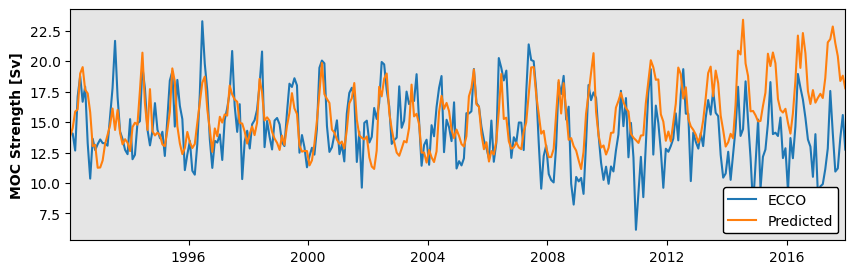

In [174]:
# Extracting all predictions in time order
train_set_pred = train.predict(model, 'CNN1D', Xt_train, Yt_train, save_dir=save_dir)
test_set_pred = train.predict(model, 'CNN1D', Xt_test, Yt_test, save_dir=save_dir)
all_preds = np.concatenate([train_set_pred, test_set_pred])

r2 = round(r2_score(test_set_pred, y_test), 3)
mse = round(mean_squared_error(test_set_pred, y_test), 3)
rmse = round(root_mean_squared_error(test_set_pred, y_test), 3)
mae = round(mean_absolute_error(test_set_pred, y_test), 3)

print(f"Test R^2: {r2}")
print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")

time = outputs.time.values[-X.shape[0]:]

fig, ax = timeseries_comparison(all_preds, y, time, len(y))
plt.show()

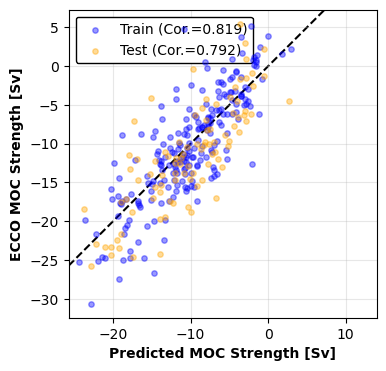

In [96]:
# Alternate view: looking at a scatterplot of predicted vs. actual
y_pred_train = np.array(train_set_pred).squeeze()
y_pred_test = np.array(test_set_pred).squeeze()

fig, ax = pred_vs_actual(y_pred_train, y_pred_test, y_train, y_test)
plt.show()